In [1]:
import pandas as pd
import numpy as np

In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

Using backend: pytorch


In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn import preprocessing

### Resources
https://www.kaggle.com/rounakbanik/the-movies-dataset<br>
https://docs.dgl.ai/en/0.6.x/generated/dgl.DGLHeteroGraph.ndata.html?highlight=ndata#dgl.DGLHeteroGraph.ndata<br>
https://docs.dgl.ai/en/0.6.x/generated/dgl.heterograph.html<br>
https://docs.dgl.ai/en/0.6.x/guide/message-heterograph.html<br>
https://docs.dgl.ai/en/0.6.x/tutorials/basics/5_hetero.html<br>

In [5]:
df = pd.read_csv('ratings.csv')

In [6]:
df.groupby('userId').size().describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
dtype: float64

In [7]:
df.groupby('movieId').size().describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
dtype: float64

In [8]:
df.drop(columns=['timestamp'], inplace=True)

In [9]:
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [10]:
encoders = {
    'user': preprocessing.LabelEncoder(),
    'movie': preprocessing.LabelEncoder(),
}

In [11]:
df['encoded_user'] = encoders['user'].fit_transform(df.userId)
df['encoded_movie'] = encoders['movie'].fit_transform(df.movieId)

In [12]:
df.encoded_user.describe()

count    100836.000000
mean        325.127564
std         182.618491
min           0.000000
25%         176.000000
50%         324.000000
75%         476.000000
max         609.000000
Name: encoded_user, dtype: float64

## Graph construction
Dataset`ratings_small`: rating as edge feature

In [13]:
data_dict = {
    ('user', 'rates', 'movie'): (torch.tensor(df.encoded_user), torch.tensor(df.encoded_movie))
}

#num_nodes_dict = {'user': df.userId.nunique(), 'movie': df.movieId.nunique()}

g = dgl.heterograph(data_dict)

In [14]:
g

Graph(num_nodes={'movie': 9724, 'user': 610},
      num_edges={('user', 'rates', 'movie'): 100836},
      metagraph=[('user', 'movie', 'rates')])

In [15]:
g.edata['rating'] = torch.tensor(df.rating)

## Training and test set
https://docs.dgl.ai/tutorials/blitz/4_link_predict.html?highlight=split%20edge%20set%20training%20testing

In [16]:
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)

# 20% test
test_size = int(len(eids) * 0.2)
train_size = g.number_of_edges() - test_size


train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]

#### Negative sampling

In [17]:
# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = -1*adj.todense()+1
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [18]:
assert adj.todense()[neg_u,neg_v].all() == 0

In [19]:
train_g = dgl.remove_edges(g, eids[:test_size])

## GNN Definition

In [20]:
import dgl.function as fn

In [21]:
class CustomGNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        
        super(CustomGNN, self).__init__()
        
        # Weights
        self.user_w = nn.Parameter(torch.FloatTensor(in_dim,out_dim))
        self.movie_w = nn.Parameter(torch.FloatTensor(in_dim,out_dim))
        self.edge_w = nn.Parameter(torch.FloatTensor(1,out_dim))
            
        self.reset_parameters()
        
        
    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        
        #attention layer init
        nn.init.xavier_normal_(self.user_w, gain=gain)
        nn.init.xavier_normal_(self.movie_w, gain=gain)
        nn.init.xavier_normal_(self.edge_w, gain=gain)
        
    def forward(self, g, user_feat, movie_feat, edge_features):
        with g.local_scope():
            g.ndata['feat'] = {'movie':movie_feat@self.movie_w, 'user':user_feat@self.user_w}
            g.edata['e_feat'] = edge_features.view(-1,1).float()@self.edge_w
            
            g.update_all(fn.u_mul_e('feat', 'e_feat', 'm'), fn.mean('m', 'h_out'))
            
            # User nodes dont get updated in message passing
            g.nodes['user'].data['h_out'] = g.ndata['feat']['user']
            
            return {ntype : g.nodes[ntype].data['h_out'] for ntype in g.ntypes}

In [22]:
user_feat = nn.Embedding(g.num_nodes('user'), 128)
movie_feat = nn.Embedding(g.num_nodes('movie'), 128)

In [23]:
gnn = CustomGNN(128, 256)

In [24]:
out = gnn(g, user_feat.weight, movie_feat.weight, g.edata['rating'])

In [25]:
out['movie'].shape

torch.Size([9724, 256])

In [26]:
out['user'].shape

torch.Size([610, 256])

#### Continue link prediction: dgl
https://docs.dgl.ai/en/0.7.x/tutorials/blitz/4_link_predict.html<br>
https://docs.dgl.ai/en/0.6.x/_modules/dgl/nn/pytorch/hetero.html

In [27]:
from dgl.nn.pytorch.hetero import HeteroGraphConv

In [28]:
conv = HeteroGraphConv({'rates' : dgl.nn.SAGEConv(256,256, aggregator_type='mean')})

In [29]:
conv(g, out)

{'movie': tensor([[ 0.0764,  0.1014, -0.1377,  ...,  0.0535, -0.0706,  0.1194],
         [-0.1057,  0.1146, -0.1099,  ..., -0.0080, -0.1842, -0.0786],
         [-0.0094,  0.2508, -0.1189,  ...,  0.1302, -0.2630, -0.0063],
         ...,
         [ 1.4065,  1.1600, -0.0986,  ..., -1.9606,  1.0268, -1.9804],
         [ 1.4065,  1.1600, -0.0986,  ..., -1.9606,  1.0268, -1.9804],
         [ 1.4124, -0.1457, -0.3143,  ..., -0.2758, -2.5192, -2.3234]],
        grad_fn=<SumBackward1>)}

In [30]:
from dgl.nn import SAGEConv

class GraphSAGEHetero(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGEHetero, self).__init__()
        self.conv = CustomGNN(in_feats, h_feats)
        self.conv1 = HeteroGraphConv({'rates' : dgl.nn.SAGEConv(h_feats,h_feats, aggregator_type='mean')})
        self.conv2 = HeteroGraphConv({'rates' : dgl.nn.SAGEConv(h_feats,h_feats, aggregator_type='mean')})
    
    def forward(self, g, user_feat, movie_feat, edge_features):
        
        out = self.conv(g, user_feat, movie_feat, edge_features)
        
        hidden = self.conv1(g, out)
        hidden['user'] = out['user']
        hidden['movie'] = F.relu(hidden['movie'])
        
        
        h = self.conv2(g, hidden)
        h['user'] = hidden['user']
        
        return h

In [31]:
gnn = GraphSAGEHetero(128, 256)

---

#### Positive and Negative graph

In [32]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

#### Pred test

In [33]:
class DotPredictor(nn.Module):
    def forward(self, g, user_feat, movie_feat):
        u, v = g.edges()
        
        dot = (user_feat[u]*movie_feat[v]).sum(1)
        
        return dot
    
    def predict(self, nodes_u, nodes_v):
        return torch.sigmoid((nodes_u*nodes_v).sum(1))

In [34]:
gnn = GraphSAGEHetero(128, 256)
out = gnn(train_g, user_feat.weight, movie_feat.weight, g.edata['rating'][eids[test_size:]])

In [35]:
pred = DotPredictor()
pred(train_g, user_feat.weight, movie_feat.weight)

tensor([-14.4936,  -1.3872,  11.9105,  ...,  -3.3919, -10.7164,  10.6651],
       grad_fn=<SumBackward1>)

In [36]:
train_pos_g.edges()

(tensor([326, 118, 181,  ..., 198, 317, 566]),
 tensor([ 733, 3185, 1235,  ..., 5721, 2760, 8155]))

### Train loop

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [38]:


# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(hidden)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

def compute_recall(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    scores = torch.sigmoid(scores)
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return recall_score(labels, torch.round(scores))

def compute_precision(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    scores = torch.sigmoid(scores)
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return precision_score(labels, torch.round(scores))

In [51]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop

user_feat = nn.Embedding(g.num_nodes('user'), 16)
movie_feat = nn.Embedding(g.num_nodes('movie'), 16)
model = GraphSAGEHetero(16, 32)
pred = DotPredictor()

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), 
                                             pred.parameters(), 
                                             user_feat.parameters(), 
                                             movie_feat.parameters()), 
                             lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(200):
    # forward
    h = model(train_g, user_feat.weight, movie_feat.weight, g.edata['rating'][eids[test_size:]])
    pos_score = pred(train_g, user_feat.weight, movie_feat.weight)
    neg_score = pred(train_neg_g, user_feat.weight, movie_feat.weight)
    
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, user_feat.weight, movie_feat.weight)
    neg_score = pred(test_neg_g, user_feat.weight, movie_feat.weight)
    print('AUC', compute_auc(pos_score, neg_score))
    print('Recall', compute_recall(pos_score, neg_score))
    print('Precision', compute_precision(pos_score, neg_score))


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

In epoch 0, loss: 1.7425562143325806
In epoch 5, loss: 1.576704502105713
In epoch 10, loss: 1.4283771514892578
In epoch 15, loss: 1.297072410583496
In epoch 20, loss: 1.1816489696502686
In epoch 25, loss: 1.0805715322494507
In epoch 30, loss: 0.9921039342880249
In epoch 35, loss: 0.9144470691680908
In epoch 40, loss: 0.8458298444747925
In epoch 45, loss: 0.7845719456672668
In epoch 50, loss: 0.7291359901428223
In epoch 55, loss: 0.6781813502311707
In epoch 60, loss: 0.6306167244911194
In epoch 65, loss: 0.5856469869613647
In epoch 70, loss: 0.5427975058555603
In epoch 75, loss: 0.5018985867500305
In epoch 80, loss: 0.4630218744277954
In epoch 85, loss: 0.42638102173805237
In epoch 90, loss: 0.39221784472465515
In epoch 95, loss: 0.36070623993873596
In epoch 100, loss: 0.3319026231765747
In epoch 105, loss: 0.3057484030723572
In epoch 110, loss: 0.2820996940135956
In epoch 115, loss: 0.2607637643814087
In epoch 120, loss: 0.24153059720993042
In epoch 125, loss: 0.22419339418411255
In ep

## Testing

#### Read movie data

In [52]:
df_movies = pd.read_csv('movies.csv')

#### Get embeddings

In [53]:
with torch.no_grad():
    features = model(g, user_feat.weight, movie_feat.weight, g.edata['rating'])

In [54]:
features['user'].shape

torch.Size([610, 32])

In [55]:
features['movie'].shape

torch.Size([9724, 32])

#### Params

In [56]:
k = 10

#### User id #0

In [71]:
idx = 17

user_emb = features['user'][idx]

In [72]:
top_k_user = df[df.encoded_user == idx][['movieId', 'rating']].sort_values('rating', ascending=False).iloc[:k]

In [73]:
df_movies[df_movies.movieId.isin(top_k_user.movieId)]

,movieId,title,genres
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
705,923,Citizen Kane (1941),Drama|Mystery
903,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western
905,1203,12 Angry Men (1957),Drama
910,1209,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western
922,1221,"Godfather: Part II, The (1974)",Crime|Drama
2222,2951,"Fistful of Dollars, A (Per un pugno di dollari...",Action|Western
2945,3949,Requiem for a Dream (2000),Drama
8457,112334,"Internet's Own Boy: The Story of Aaron Swartz,...",Documentary


### Recommended movies

In [74]:
prediction = pred.predict(user_emb.view(1,-1),features['movie'])
prediction_index = prediction.topk(k).indices

<AxesSubplot:ylabel='Frequency'>

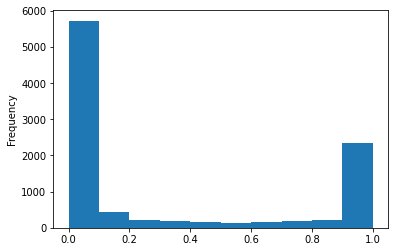

In [75]:
pd.Series(prediction).plot.hist()

In [76]:
df_movies[df_movies.movieId.isin(encoders['movie'].inverse_transform(prediction_index))]

,movieId,title,genres
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
36,40,"Cry, the Beloved Country (1995)",Drama
50,55,Georgia (1995),Drama
91,103,Unforgettable (1996),Mystery|Sci-Fi|Thriller
102,117,"Young Poisoner's Handbook, The (1995)",Crime|Drama
121,148,"Awfully Big Adventure, An (1995)",Drama
188,220,Castle Freak (1995),Horror
204,238,Far From Home: The Adventures of Yellow Dog (1...,Adventure|Children
207,241,Fluke (1995),Children|Drama
233,271,Losing Isaiah (1995),Drama


In [77]:
df_movies[df_movies.movieId.isin(top_k_user.movieId)]

,movieId,title,genres
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
705,923,Citizen Kane (1941),Drama|Mystery
903,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western
905,1203,12 Angry Men (1957),Drama
910,1209,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western
922,1221,"Godfather: Part II, The (1974)",Crime|Drama
2222,2951,"Fistful of Dollars, A (Per un pugno di dollari...",Action|Western
2945,3949,Requiem for a Dream (2000),Drama
8457,112334,"Internet's Own Boy: The Story of Aaron Swartz,...",Documentary
